[Info] Calculating Static Beta & Z-Score (robust)...
  WINDOW_BETA = 1500, WINDOW_Z = 300
  MIN_BETA_PERIOD = 150, MIN_Z_PERIOD = 30
[Info] Rows total: 122630, rows with Z_Score: 117436 (>=0 means usable)
[Info] Simulating Pairs Strategy: ENTRY=2.0, EXIT=0.5
[Info] Total trade events (approx): 417.0

 PERFORMANCE REPORT: Static Cointegration Strategy (CAD/AUD)


,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (CAD),Trades (AUD),Av. Trades,Stat
0,2023_Q1,1.892537,0.765116,4141.513768,1.892537,2.433848,2400.800098,980.800098,71.0,71.0,1.820513,0.000000
1,2023_Q3,1.973056,1.171417,5008.054457,1.973056,3.200251,3075.827769,1815.827769,63.0,63.0,1.615385,0.400528
2,2023_Q4,-0.340320,-1.313412,3900.398264,-0.340320,-1.643935,-405.637834,-1585.637834,59.0,59.0,1.512821,-0.835959
3,2024_Q2,-0.935021,-1.846325,3677.752039,-0.935021,-2.971330,-1028.713036,-2128.713036,55.0,55.0,1.392405,-1.772690
4,2024_Q4,0.693363,-0.256331,3807.227650,0.693363,-0.417225,834.059725,-305.940275,57.0,57.0,1.443038,-0.000000
5,2025_Q1,-1.333071,-2.516642,2963.359283,-1.333071,-2.943806,-1178.746238,-2278.746238,55.0,55.0,1.428571,-2.484583
6,2025_Q2,-1.281413,-2.084049,4490.806272,-1.281413,-2.171639,-1793.991449,-2933.991449,57.0,57.0,1.443038,-2.781377
7,TOTAL,NaN,NaN,4036.271250,NaN,NaN,1903.599035,-6436.400965,417.0,417.0,1.522253,-7.474081



 TOTAL RANKING SCORE: -7.4741


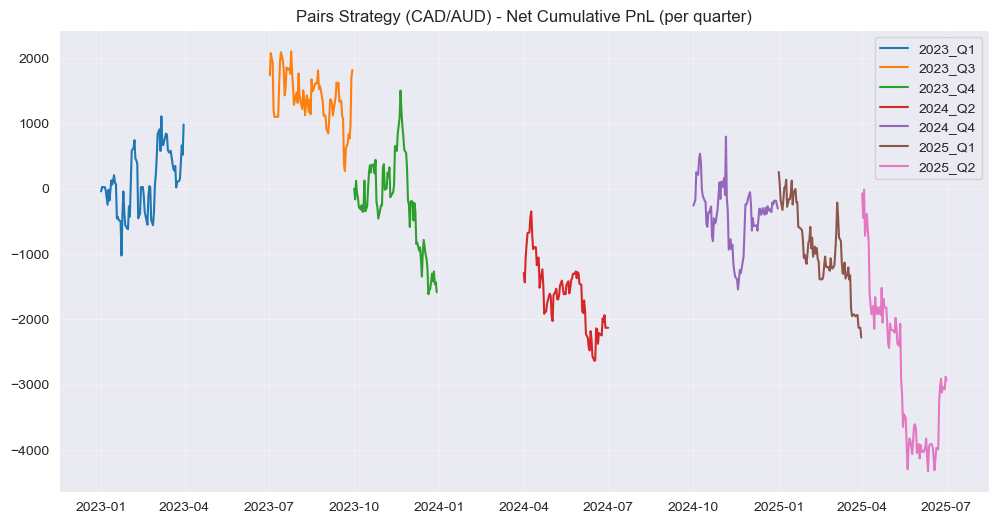

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')


class Config:
    # File Path
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['CAD', 'AUD']  # CAD = Y, AUD = X

    # Contract Specs
    SPECS = {
        'CAD': {'point_val': 100000.0, 'cost': 10.0},
        'AUD': {'point_val': 100000.0, 'cost': 10.0}
    }

    # --- Strategy Parameters (keep semantics unchanged) ---
    WINDOW_BETA = 1500   # rolling window for beta (unchanged from your spec)
    WINDOW_Z = 300       # rolling window for z-score
    ENTRY_THRESHOLD = 2.0
    EXIT_THRESHOLD = 0.5

    ANNUALIZATION = 252

    # Robustness knobs (internal, safe defaults)
    MIN_BETA_PERIOD = max(10, int(WINDOW_BETA * 0.1))  # min periods to compute beta
    MIN_Z_PERIOD = max(10, int(WINDOW_Z * 0.1))


# --------------------------
# 2. Data preparation
# --------------------------
def prepare_pairs_data(file_path, cfg):
    """
    Loads data and computes rolling beta and z-score.
    Preserves per-quarter grouping while being robust to small quarter lengths.
    Returns a DataFrame with additional columns: Beta, Spread, Z_Score.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"[Error] File not found: {file_path}")
        return None

    # Required columns: CAD, AUD, Quarter_ID
    req_cols = set(cfg.ASSETS + ['Quarter_ID'])
    if not req_cols.issubset(df.columns):
        missing = req_cols.difference(df.columns)
        print(f"[Error] Missing required columns: {missing}")
        return None

    data = df[cfg.ASSETS + ['Quarter_ID'] + (['Is_In_Sample'] if 'Is_In_Sample' in df.columns else [])].copy()
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("[Info] Calculating Static Beta & Z-Score (robust)...")
    print(f"  WINDOW_BETA = {cfg.WINDOW_BETA}, WINDOW_Z = {cfg.WINDOW_Z}")
    print(f"  MIN_BETA_PERIOD = {cfg.MIN_BETA_PERIOD}, MIN_Z_PERIOD = {cfg.MIN_Z_PERIOD}")

    # We'll compute on each Quarter_ID but with safe min_periods to avoid entire-quarter NaN
    def calc_cointegration_metrics(group):
        g = group.copy()

        # convert to notional (price * point_val) for beta calc as in your original code
        y = g['CAD'] * cfg.SPECS['CAD']['point_val']   # Y
        x = g['AUD'] * cfg.SPECS['AUD']['point_val']   # X

        # Rolling cov and var with min_periods for robustness
        cov = x.rolling(window=cfg.WINDOW_BETA, min_periods=cfg.MIN_BETA_PERIOD).cov(y)
        var = x.rolling(window=cfg.WINDOW_BETA, min_periods=cfg.MIN_BETA_PERIOD).var()

        # Avoid division by zero: set var very small -> NaN
        var_safe = var.copy()
        var_safe[var_safe.abs() < 1e-8] = np.nan

        beta = cov / var_safe

        # Clean up infinities/nans: forward/backfill then default 1.0
        beta = beta.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(1.0)

        # Spread in notional units
        spread = y - (beta * x)

        # Z-score rolling with min_periods
        spread_mean = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).mean()
        spread_std = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).std()

        # avoid division by zero
        spread_std_safe = spread_std.copy()
        spread_std_safe[spread_std_safe.abs() < 1e-12] = np.nan

        z_score = (spread - spread_mean) / spread_std_safe

        # Align into DataFrame columns (use original index)
        g.loc[:, 'Beta'] = beta.values
        g.loc[:, 'Spread'] = spread.values
        g.loc[:, 'Z_Score'] = z_score.values

        return g

    # Apply per Quarter_ID but keep index alignment
    data_out = data.groupby('Quarter_ID', group_keys=False).apply(calc_cointegration_metrics)

    # Report how many rows have valid Z
    n_total = len(data_out)
    n_z = data_out['Z_Score'].notna().sum()
    print(f"[Info] Rows total: {n_total}, rows with Z_Score: {n_z} (>=0 means usable)")

    # Do not force-drop all NaNs; keep rows (strategy will skip NaN z)
    return data_out


# --------------------------
# 3. Strategy logic
# --------------------------
def run_pairs_strategy(df, cfg):
    """
    Executes trades from Z-Score signals.
    Strategy logic unchanged: entry when |z| > ENTRY, exit when |z| < EXIT.
    Positions are lagged by 1 bar (shift) to avoid look-ahead.
    """
    data = df.copy()
    if data.empty:
        print("[Warning] Empty DataFrame passed to strategy.")
        return data

    # Prepare arrays
    z = data['Z_Score'].values
    in_sample = data['Is_In_Sample'].values if 'Is_In_Sample' in data.columns else np.ones(len(data), dtype=bool)

    pos_cad = np.zeros(len(data), dtype=int)
    pos_aud = np.zeros(len(data), dtype=int)
    curr_cad = 0
    curr_aud = 0

    print(f"[Info] Simulating Pairs Strategy: ENTRY={cfg.ENTRY_THRESHOLD}, EXIT={cfg.EXIT_THRESHOLD}")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_cad = 0
            curr_aud = 0
            pos_cad[i] = 0
            pos_aud[i] = 0
            continue

        zi = z[i]
        # If z is NaN, do nothing (hold current pos)
        if np.isnan(zi):
            pos_cad[i] = curr_cad
            pos_aud[i] = curr_aud
            continue

        # Entry
        if curr_cad == 0 and curr_aud == 0:
            if zi > cfg.ENTRY_THRESHOLD:
                # Sell spread: Sell CAD, Buy AUD
                curr_cad = -1
                curr_aud = 1
            elif zi < -cfg.ENTRY_THRESHOLD:
                curr_cad = 1
                curr_aud = -1
        else:
            # Exit when abs(z) < EXIT_THRESHOLD
            if abs(zi) < cfg.EXIT_THRESHOLD:
                curr_cad = 0
                curr_aud = 0

        pos_cad[i] = curr_cad
        pos_aud[i] = curr_aud

    # Lag positions by 1 bar to simulate execution on next bar
    data['Pos_CAD'] = pd.Series(pos_cad, index=data.index).shift(1).fillna(0).astype(int)
    data['Pos_AUD'] = pd.Series(pos_aud, index=data.index).shift(1).fillna(0).astype(int)

    # Add a debug summary
    n_trades = (data['Pos_CAD'].diff().abs().sum() + data['Pos_AUD'].diff().abs().sum()) / 2.0
    print(f"[Info] Total trade events (approx): {n_trades}")

    return data


# --------------------------
# 4. P&L calculation & aggregation
# --------------------------
def calculate_metrics(data, cfg):
    df = data.copy()
    if df.empty:
        return pd.DataFrame()

    # Price diffs (raw prices)
    df['dPrice_CAD'] = df['CAD'].diff()
    df['dPrice_AUD'] = df['AUD'].diff()

    # Gross PnL: position * price change * point value
    df['Gross_PnL_CAD'] = df['Pos_CAD'] * df['dPrice_CAD'] * cfg.SPECS['CAD']['point_val']
    df['Gross_PnL_AUD'] = df['Pos_AUD'] * df['dPrice_AUD'] * cfg.SPECS['AUD']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_CAD'].fillna(0) + df['Gross_PnL_AUD'].fillna(0)

    # Trades & costs
    df['Trades_CAD'] = df['Pos_CAD'].diff().abs().fillna(0)
    df['Trades_AUD'] = df['Pos_AUD'].diff().abs().fillna(0)
    df['Cost_Total'] = (df['Trades_CAD'] * cfg.SPECS['CAD']['cost']) + (df['Trades_AUD'] * cfg.SPECS['AUD']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_CAD'] + df['Trades_AUD']

    # Daily aggregation
    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_CAD': 'sum',
        'Trades_AUD': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    # Filter only valid quarters and in-sample days
    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# --------------------------
# 5. Reporting
# --------------------------
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if (std_g and not np.isnan(std_g)) else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n)) else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION) if (std_n and not np.isnan(std_n)) else 0

        years = len(d_q) / cfg.ANNUALIZATION if cfg.ANNUALIZATION > 0 else 1.0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n and max_dd_n > 0) else 0

        trades_cad = d_q['Trades_CAD'].sum()
        trades_aud = d_q['Trades_AUD'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': 0.0 if np.isnan(gross_sr) else gross_sr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (CAD)': trades_cad,
            'Trades (AUD)': trades_aud,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return
    quarters = sorted(daily_stats['Quarter_ID'].unique())
    plt.figure(figsize=(12, 6))
    for q in quarters:
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].copy()
        plt.plot(d_q.index, d_q['Net_PnL_Total'].cumsum(), label=q)
    plt.title('Pairs Strategy (CAD/AUD) - Net Cumulative PnL (per quarter)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# --------------------------
# 6. Main
# --------------------------
if __name__ == "__main__":
    cfg = Config()
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is None or df_prep.empty:
        print("[Error] No data after preparation. Exiting.")
    else:
        df_res = run_pairs_strategy(df_prep, cfg)
        daily_data = calculate_metrics(df_res, cfg)
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Static Cointegration Strategy (CAD/AUD)")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_cad = stats_table['Trades (CAD)'].sum()
            total_trades_aud = stats_table['Trades (AUD)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION) if not np.isnan(std_global) else 0.0

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (CAD)': total_trades_cad,
                'Trades (AUD)': total_trades_aud,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)
            display(display_df)

            print(f"\n{'=' * 40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'=' * 40}")

            plot_equity_curve(daily_data)
        else:
            print("⚠️ No statistics generated.")
